Tutorial based on https://www.youtube.com/watch?v=vV12dGe_Fho&t=937s&ab_channel=RobMulla

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

There are a few types of time series data:

1. Random Error - no recognizable pattern
2. Exponential growth
3. Linear Trend
4. seasonal Pattern
5. Seasonal Pattern and Linear Growth


In [123]:
df = pd.read_csv('PJME_hourly.csv')

In [124]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [125]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [126]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [127]:
df = df.set_index('Datetime')

In [128]:
color_pal = sns.color_palette()

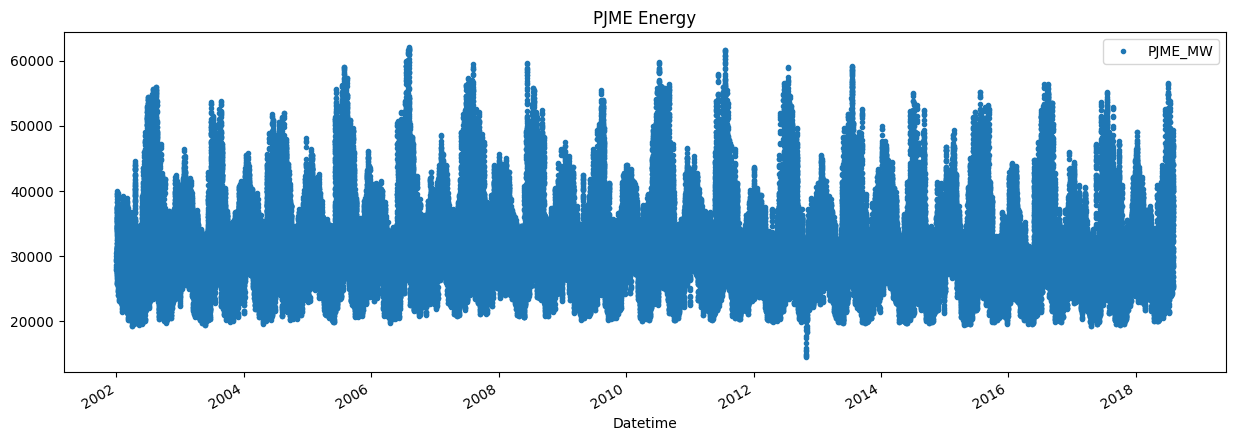

In [129]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title="PJME Energy")
plt.show()


# Train / Test Split

In [130]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


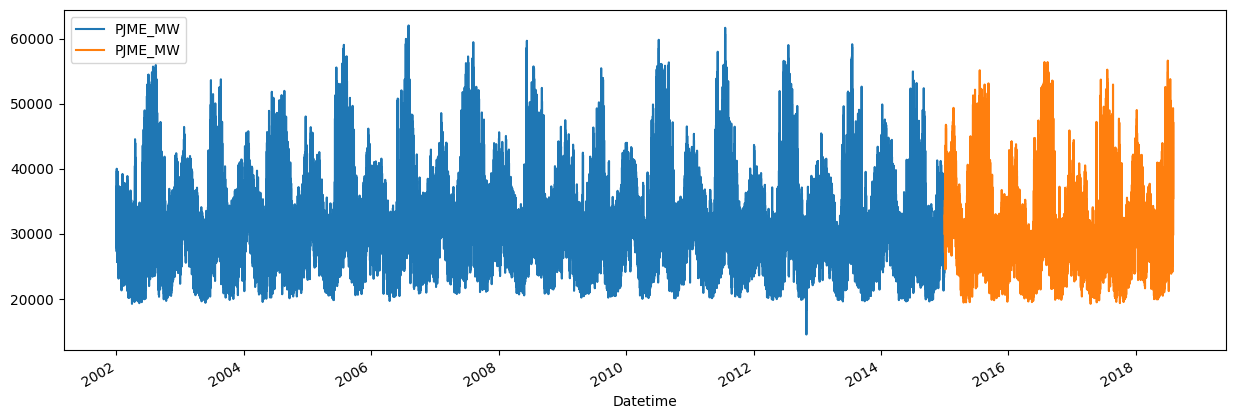

In [131]:
# Test split at Jan 2015
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax= ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
# ax.axvline('0')
plt.show()


In [132]:
train

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2014-01-01 20:00:00,36193.0
2014-01-01 21:00:00,35601.0
2014-01-01 22:00:00,34242.0


In [133]:
test

,PJME_MW
Datetime,
2015-01-01 00:00:00,32802.0
2015-12-31 01:00:00,24305.0
2015-12-31 02:00:00,23156.0
2015-12-31 03:00:00,22514.0
2015-12-31 04:00:00,22330.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [110]:
test

,PJME_MW
Datetime,
31.12.2002 01:00:00,26498.0
31.12.2002 02:00:00,25147.0
31.12.2002 03:00:00,24574.0
31.12.2002 04:00:00,24393.0
31.12.2002 05:00:00,24860.0
...,...
21.01.2018 21:00:00,31294.0
21.01.2018 22:00:00,30009.0
21.01.2018 23:00:00,28503.0
